In [ ]:
ufrom google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.layers import Embedding, Dense, Dropout, Input, LSTM, Bidirectional,GRU
from keras.layers import MaxPooling1D, Conv1D, Flatten
from keras.preprocessing import sequence, text
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import Callback

from gensim.models.keyedvectors import KeyedVectors
from sklearn import preprocessing
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from keras import optimizers

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.utils import class_weight

from sklearn import preprocessing
from sklearn.metrics import (
    classification_report as creport
)

# Data and AraVec2.0 (pre-trained word embeddings model) Loading

In [ ]:
#pre-trained word embedding: https://github.com/bakrianoo/aravec/tree/master/AraVec%202.0
"""
Citation:
Abu Bakr Soliman, Kareem Eisa, and Samhaa R. El-Beltagy, “AraVec:
A set of Arabic Word Embedding Models for use in Arabic NLP”,
in proceedings of the 3rd International Conference on 
Arabic Computational Linguistics (ACLing 2017), Dubai, UAE, 2017.
"""
! unzip '/content/drive/MyDrive/tweets_sg_300.zip'  

Archive:  /content/drive/MyDrive/tweets_sg_300.zip
  inflating: tweets_sg_300           
  inflating: tweets_sg_300.trainables.syn1neg.npy  
  inflating: tweets_sg_300.wv.vectors.npy  


In [ ]:
# Word_embedding_path
embedding_path = '/content/tweets_sg_300'           #Twitter-Skipgram model-300d(trained on 77,600,000 Arabic tweets)

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/train.csv')
train_data

,Tweet,Class
0,وزير الخارجية اللبناني جبران باسيل قال في سلسل...,normal
1,سورية بلد الحضارات تربطها بعلية او بحيوان,normal
2,اخي الحاج اذا شعرت انك محرجا من الانتقادات لتص...,normal
3,ما فيك تعيش بلا ما تكب فتن ليل نهار وبكرة قلهم...,normal
4,هذا البطل الذي قاتل وجاذف بحياته لتحيا انت يا ...,abusive
...,...,...
4671,كول هوا مرة تانيي وحلوا عن طيزو وطيزنا ومقلعين...,abusive
4672,رئيس روحي؟ تروح روحك انت وكل مين شدّ عمشدّك مش...,abusive
4673,إذا أرادت إسرائيل أن تضمن أمنها وهو حق عليها ا...,normal
4674,خليك بحالك يا نعيمي على أساس أنت مش مرتزق و طب...,abusive


In [ ]:
print("Train data shape: {}".format(train_data.shape))

Train data shape: (4676, 2)


In [ ]:
def get_embedding_matrix(word_index, embedding_index, vocab_dim):
    print('Building embedding matrix...')
    embedding_matrix = np.zeros((len(word_index) + 1, vocab_dim))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index.get_vector(word)
        except:
            pass
    print('Embedding matrix built.') 
    #print("Word index", word_index.items())
    #print(embedding_matrix) 
    return embedding_matrix


def get_init_parameters(path, ext=None):
    if ext == 'vec':
        word_model = KeyedVectors.load_word2vec_format(path).wv
    else:
        word_model = KeyedVectors.load(path).wv
    n_words = len(word_model.vocab)
    vocab_dim = word_model[word_model.index2word[0]].shape[0]
    index_dict = dict()
    for i in range(n_words):
        index_dict[word_model.index2word[i]] = i+1
    print('Number of words in the word embedding',n_words)
    #print('word_model', word_model)
    #print("index_dict",index_dict)
    return word_model, index_dict, n_words, vocab_dim

def get_max_length(text_data, return_line=False):
    max_length = 0
    long_line = ""
    for line in text_data:
        new = len(line.split())
        if new > max_length:
            max_length = new
            long_line = line
    if return_line:
        return long_line, max_length
    else:
        return max_length
    print("max",long_line,max_length)

def load_datasets(data_paths, header=True):
    x = []
    y = []
    for data_path in data_paths:
        with open(data_path, 'r') as f:
            for line in f:
                if header:
                    header = False
                else:
                    temp = line.split(',')
                    x.append(temp[0])
                    y.append(temp[1].replace('\n', ''))
    max_length = get_max_length(x)
    print('Max length:', max_length)
    return x,y, max_length

def get_train_test(train_raw_text, test_raw_text, n_words, max_length):
    tokenizer = text.Tokenizer(num_words=n_words)
    tokenizer.fit_on_texts(list(train_raw_text))
    word_index = tokenizer.word_index
   
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)

    return sequence.pad_sequences(train_tokenized, maxlen=max_length, padding='post', truncating='post'),\
           sequence.pad_sequences(test_tokenized, maxlen=max_length, padding='post', truncating='post'),\
           word_index

def class_str_2_ind(x_train, x_test, y_train, y_test, classes, n_words, max_length):
    print('Converting data to trainable form...')
    y_encoder = preprocessing.LabelEncoder()
    y_encoder.fit(classes)
    y_train = y_encoder.transform(y_train)
    y_test = y_encoder.transform(y_test)
    #print(y_train)
    #print(y_test)
    train_y_cat = np_utils.to_categorical(y_train, len(classes))
    x_vec_train, x_vec_test, word_index = get_train_test(x_train, x_test, n_words, max_length)
    print('Number of training examples: ' + str(len(x_vec_train)))
    print('Number of testing examples: ' + str(len(x_vec_test)))
    return x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index

In [ ]:
WORD_MODEL, _, MAX_FEATURES, EMBED_SIZE = get_init_parameters(embedding_path) 

Number of words in the word embedding 331679


In [ ]:
# load train data
train_data_path=["/content/drive/MyDrive/OSACT4"]
X, y, MAX_TEXT_LENGTH = load_datasets(train_data_path)
CLASSES_LIST = np.unique(y)
print('Label categories: ' + str(CLASSES_LIST))

Max length: 52
Label categories: ['abusive' 'hate' 'normal']


In [ ]:
MAX_TEXT_LENGTH=52

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train, X_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(X_train, X_test, y_train, y_test, CLASSES_LIST, MAX_FEATURES, MAX_TEXT_LENGTH)
test_cat_y = np_utils.to_categorical(y_test, len(CLASSES_LIST))

Converting data to trainable form...
Number of training examples: 3740
Number of testing examples: 936


In [ ]:
print("Tokens number: "+ str(len(word_index)))

Tokens number: 14157


In [ ]:
# Sequence length
print("Original sequence length: "+str(MAX_TEXT_LENGTH))

Original sequence length: 52


In [ ]:
def get_model(embedding_weights, word_index, vocab_dim, max_length,layer, dropout, optimizer, print_summary=True):
    """
    Create Neural Network With an Embedding layer
    """
    inp = Input(shape=(max_length,))
    model = Embedding(input_dim=len(word_index)+1,
                      output_dim=vocab_dim,
                      trainable=False,
                      weights=[embedding_weights])(inp)
    model = layer(model)
    model = Dropout(dropout)(model)       
    model = Flatten()(model)
    model = Dense(3, activation='sigmoid')(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    if print_summary:
        model.summary()
    return model


def get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH, 
                   layer, dropout,optimizer):
   
    tmp = get_embedding_matrix(word_index, WORD_MODEL, EMBED_SIZE)
    model = get_model(tmp, word_index, EMBED_SIZE, MAX_TEXT_LENGTH, 
                      layer, dropout, optimizer= optimizer ,print_summary=True)
    return model

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

def train_fit_predict(model, x_train, x_test, y_train, y_test, class_weight, batch_size, epochs, TestCallback=TestCallback):
   
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs, verbose=1,
                        validation_data=(x_test, y_test),
                        class_weight=class_weight,
                        callbacks=[TestCallback((x_test, y_test))])
    return history, model

#### Note: the prior work is the same for all of the neural learning models.

#  RNN (LSTM) Model

In [ ]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH, 
                       layer= LSTM(units=16, return_sequences=True, return_state=False), dropout=0.5, 
                       optimizer= optimizers.Adam(0.001))

Building embedding matrix...
Embedding matrix built.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 52)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 52, 300)           4247400   
_________________________________________________________________
lstm (LSTM)                  (None, 52, 16)            20288     
_________________________________________________________________
dropout (Dropout)            (None, 52, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 832)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 2499      
Total params: 4,270,187
Trainable params: 22,787
Non-trainable params: 4,2

In [ ]:
X_train.shape

(3740, 52)

In [ ]:
X_test.shape

(936, 52)

In [ ]:
time_start = time()
history, model = train_fit_predict(model,
                               X_train[:, :MAX_TEXT_LENGTH],
                               X_test[:, :MAX_TEXT_LENGTH],
                               train_y_cat, test_cat_y, class_weight=None,
                               batch_size=1000, epochs=20)
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

Epoch 1/20
4/4 [==============================] - 4s 566ms/step - loss: 1.0796 - accuracy: 0.4312 - val_loss: 1.0034 - val_accuracy: 0.6325

Testing loss: 1.0033906698226929, acc: 0.632478654384613

Epoch 2/20
4/4 [==============================] - 1s 289ms/step - loss: 0.9839 - accuracy: 0.5958 - val_loss: 0.9216 - val_accuracy: 0.6485

Testing loss: 0.9216460585594177, acc: 0.6485042572021484

Epoch 3/20
4/4 [==============================] - 1s 284ms/step - loss: 0.9166 - accuracy: 0.6165 - val_loss: 0.8722 - val_accuracy: 0.6485

Testing loss: 0.8721710443496704, acc: 0.6485042572021484

Epoch 4/20
4/4 [==============================] - 1s 286ms/step - loss: 0.8897 - accuracy: 0.6186 - val_loss: 0.8461 - val_accuracy: 0.6485

Testing loss: 0.8461318016052246, acc: 0.6485042572021484

Epoch 5/20
4/4 [==============================] - 1s 287ms/step - loss: 0.8588 - accuracy: 0.6270 - val_loss: 0.8329 - val_accuracy: 0.6506

Testing loss: 0.8329213857650757, acc: 0.6506410241127014

E

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
model.evaluate(X_test[:, :MAX_TEXT_LENGTH], test_cat_y, batch_size=1000)

1/1 [==============================] - 0s 142ms/step - loss: 0.5658 - accuracy: 0.7863


[0.5658174157142639, 0.7863247990608215]

In [ ]:
y_pred = np.argmax(model.predict(X_test[:, :MAX_TEXT_LENGTH]), axis=1)

print(creport(np.argmax(test_cat_y, axis=1), y_pred,target_names=["normal", "abusive", "hate"],digits=4))

              precision    recall  f1-score   support

      normal     0.7212    0.6174    0.6653       264
     abusive     0.2727    0.0462    0.0789        65
        hate     0.8155    0.9390    0.8729       607

    accuracy                         0.7863       936
   macro avg     0.6031    0.5342    0.5390       936
weighted avg     0.7512    0.7863    0.7592       936



In [ ]:
n = np.argmin(history.history['val_loss'])

print("Optimal epoch : {}".format(n))
print("Accuracy on train : {} %".format(np.round(history.history['accuracy'][n]*100, 2)))
print("Accuracy on val : {} %".format(np.round(history.history['val_accuracy'][n]*100, 2)))
print("Loss on train : {}".format(np.round(history.history['loss'][n]*100, 2)))
print("Loss on Val : {}".format(np.round(history.history['val_loss'][n]*100, 2)))

Optimal epoch : 19
Accuracy on train : 77.75 %
Accuracy on val : 78.63 %
Loss on train : 54.84
Loss on Val : 56.58


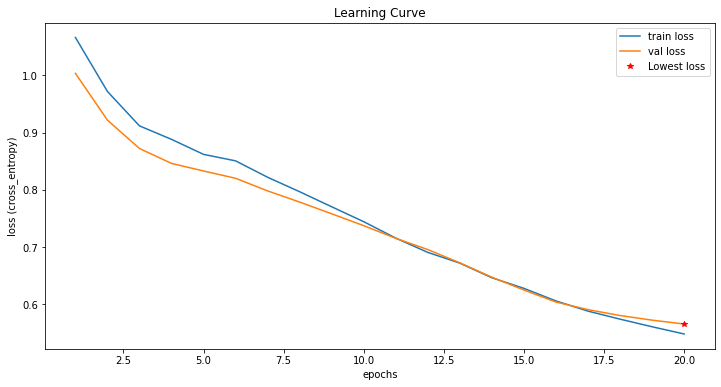

In [ ]:
plt.figure("Loss Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label="train loss")
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label="val loss")
plt.plot(n+1,history.history["val_loss"][n],"r*", label="Lowest loss")
plt.legend()
plt.title("Learning Curve")
plt.ylabel("loss (cross_entropy)")
plt.xlabel("epochs")
plt.show();

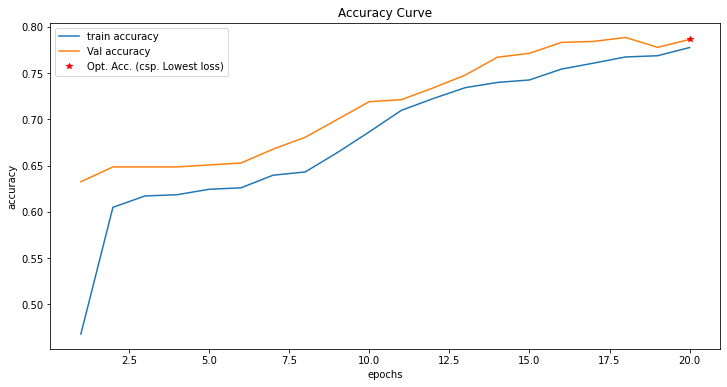

In [ ]:
plt.figure("Accuracy Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label="train accuracy")
plt.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label="Val accuracy")
plt.plot(n+1,history.history["val_accuracy"][n],"r*", label="Opt. Acc. (csp. Lowest loss)")
plt.legend()
plt.title("Accuracy Curve")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.show()

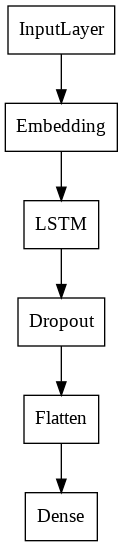

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='RNN_LSTM_model.png', show_shapes=False, show_layer_names=False)

# RNN (BLSTM) Model 


In [ ]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH, 
                       layer= Bidirectional(LSTM(units=32, return_sequences=True, return_state=False)), 
                       dropout=0.2, optimizer=optimizers.Adam())

Building embedding matrix...
Embedding matrix built.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 52)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 52, 300)           4247400   
_________________________________________________________________
bidirectional (Bidirectional (None, 52, 64)            85248     
_________________________________________________________________
dropout_1 (Dropout)          (None, 52, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3328)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9987      
Total params: 4,342,635
Trainable params: 95,235
Non-trainable params: 4

In [ ]:
time_start = time()
history, model = train_fit_predict(model,
                               X_train[:, :MAX_TEXT_LENGTH],
                               X_test[:, :MAX_TEXT_LENGTH],
                               train_y_cat, test_cat_y, class_weight=None,
                               batch_size=1000, epochs=20)
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

Epoch 1/20
4/4 [==============================] - 8s 1s/step - loss: 1.0618 - accuracy: 0.4620 - val_loss: 0.9294 - val_accuracy: 0.6485

Testing loss: 0.9293670058250427, acc: 0.6485042572021484

Epoch 2/20
4/4 [==============================] - 3s 778ms/step - loss: 0.9096 - accuracy: 0.6114 - val_loss: 0.8380 - val_accuracy: 0.6485

Testing loss: 0.8379753828048706, acc: 0.6485042572021484

Epoch 3/20
4/4 [==============================] - 3s 779ms/step - loss: 0.8464 - accuracy: 0.6199 - val_loss: 0.8064 - val_accuracy: 0.6806

Testing loss: 0.8063808083534241, acc: 0.6805555820465088

Epoch 4/20
4/4 [==============================] - 3s 789ms/step - loss: 0.8083 - accuracy: 0.6757 - val_loss: 0.7629 - val_accuracy: 0.6838

Testing loss: 0.762870728969574, acc: 0.6837607026100159

Epoch 5/20
4/4 [==============================] - 3s 781ms/step - loss: 0.7459 - accuracy: 0.6822 - val_loss: 0.7273 - val_accuracy: 0.7073

Testing loss: 0.7273138761520386, acc: 0.7072649598121643

Epoc

In [ ]:
model.evaluate(X_test[:, :MAX_TEXT_LENGTH], test_cat_y, batch_size=1000)

1/1 [==============================] - 0s 340ms/step - loss: 0.5309 - accuracy: 0.7949


[0.530890941619873, 0.7948718070983887]

In [ ]:
y_pred = np.argmax(model.predict(X_test[:, :MAX_TEXT_LENGTH]), axis=1)

print(creport(np.argmax(test_cat_y, axis=1), y_pred,target_names=["normal", "abusive", "hate"],digits=4))

              precision    recall  f1-score   support

      normal     0.7289    0.6212    0.6708       264
     abusive     0.4348    0.1538    0.2273        65
        hate     0.8285    0.9390    0.8803       607

    accuracy                         0.7949       936
   macro avg     0.6641    0.5714    0.5928       936
weighted avg     0.7731    0.7949    0.7759       936



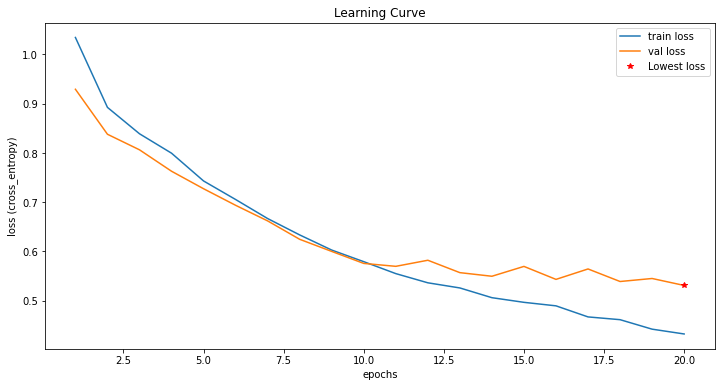

In [ ]:
plt.figure("Loss Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label="train loss")
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label="val loss")
plt.plot(n+1,history.history["val_loss"][n],"r*", label="Lowest loss")
plt.legend()
plt.title("Learning Curve")
plt.ylabel("loss (cross_entropy)")
plt.xlabel("epochs")
plt.show();

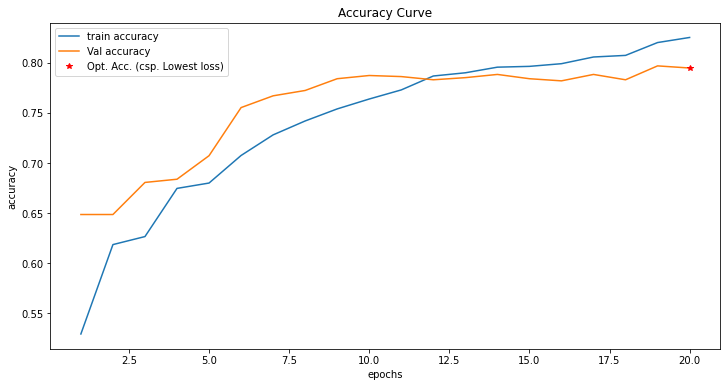

In [ ]:
plt.figure("Accuracy Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label="train accuracy")
plt.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label="Val accuracy")
plt.plot(n+1,history.history["val_accuracy"][n],"r*", label="Opt. Acc. (csp. Lowest loss)")
plt.legend()
plt.title("Accuracy Curve")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.show()

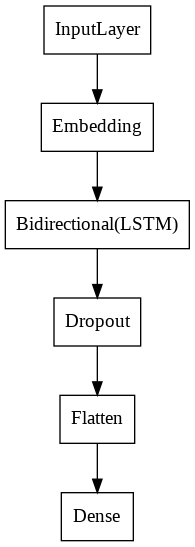

In [ ]:
plot_model(model, to_file='RNN_BLSTM_model.png', show_shapes=False, show_layer_names=False)

# RNN (GRU) Model


In [ ]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH, 
                       layer= GRU(units=16, return_sequences=True, return_state=False), 
                       dropout=0.5, optimizer=optimizers.Adam())

Building embedding matrix...
Embedding matrix built.
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 52)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 52, 300)           4247400   
_________________________________________________________________
gru (GRU)                    (None, 52, 16)            15264     
_________________________________________________________________
dropout_2 (Dropout)          (None, 52, 16)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 832)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 2499      
Total params: 4,265,163
Trainable params: 17,763
Non-trainable params: 4

In [ ]:
time_start = time()
history, model = train_fit_predict(model,
                               X_train[:, :MAX_TEXT_LENGTH],
                               X_test[:, :MAX_TEXT_LENGTH],
                               train_y_cat, test_cat_y, class_weight=None,
                               batch_size=1000, epochs=20)
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

Epoch 1/20
4/4 [==============================] - 4s 448ms/step - loss: 1.1034 - accuracy: 0.3366 - val_loss: 1.0362 - val_accuracy: 0.5940

Testing loss: 1.0361565351486206, acc: 0.5940170884132385

Epoch 2/20
4/4 [==============================] - 1s 271ms/step - loss: 1.0228 - accuracy: 0.5442 - val_loss: 0.9459 - val_accuracy: 0.6474

Testing loss: 0.9458761811256409, acc: 0.6474359035491943

Epoch 3/20
4/4 [==============================] - 1s 267ms/step - loss: 0.9365 - accuracy: 0.6164 - val_loss: 0.8678 - val_accuracy: 0.6485

Testing loss: 0.8677916526794434, acc: 0.6485042572021484

Epoch 4/20
4/4 [==============================] - 1s 265ms/step - loss: 0.8829 - accuracy: 0.6194 - val_loss: 0.8267 - val_accuracy: 0.6485

Testing loss: 0.8267066478729248, acc: 0.6485042572021484

Epoch 5/20
4/4 [==============================] - 1s 262ms/step - loss: 0.8531 - accuracy: 0.6179 - val_loss: 0.8046 - val_accuracy: 0.6485

Testing loss: 0.8046457171440125, acc: 0.6485042572021484



In [ ]:
model.evaluate(X_test[:, :MAX_TEXT_LENGTH], test_cat_y, batch_size=1000)

1/1 [==============================] - 0s 122ms/step - loss: 0.5823 - accuracy: 0.7746


[0.5823113918304443, 0.7745726704597473]

In [ ]:
y_pred = np.argmax(model.predict(X_test[:, :MAX_TEXT_LENGTH]), axis=1)

print(creport(np.argmax(test_cat_y, axis=1), y_pred,target_names=["normal", "abusive", "hate"],digits=4))

              precision    recall  f1-score   support

      normal     0.6816    0.5758    0.6242       264
     abusive     0.0000    0.0000    0.0000        65
        hate     0.8036    0.9440    0.8682       607

    accuracy                         0.7746       936
   macro avg     0.4951    0.5066    0.4975       936
weighted avg     0.7134    0.7746    0.7391       936



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


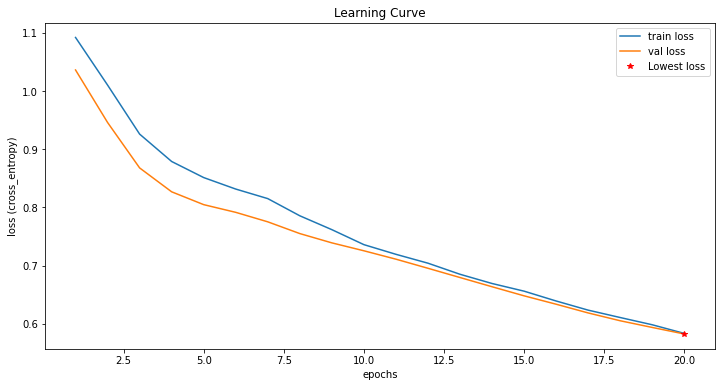

In [ ]:
plt.figure("Loss Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label="train loss")
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label="val loss")
plt.plot(n+1,history.history["val_loss"][n],"r*", label="Lowest loss")
plt.legend()
plt.title("Learning Curve")
plt.ylabel("loss (cross_entropy)")
plt.xlabel("epochs")
plt.show();

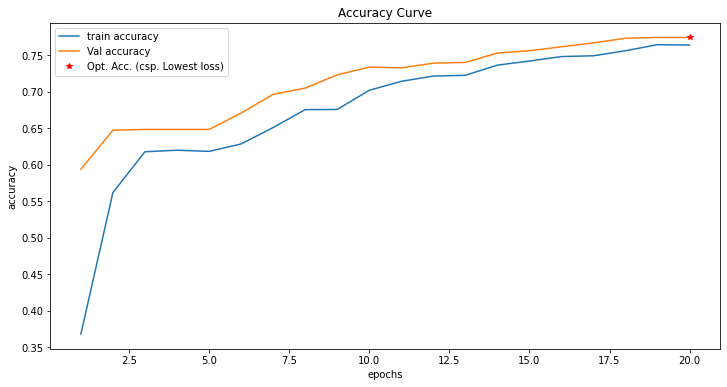

In [ ]:
plt.figure("Accuracy Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label="train accuracy")
plt.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label="Val accuracy")
plt.plot(n+1,history.history["val_accuracy"][n],"r*", label="Opt. Acc. (csp. Lowest loss)")
plt.legend()
plt.title("Accuracy Curve")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.show()

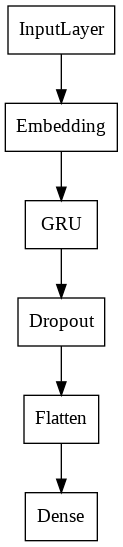

In [ ]:
plot_model(model, to_file='RNN_GRU_model.png', show_shapes=False, show_layer_names=False)